## Imports

In [1]:
import sklearn
sklearn.__file__

'/home/bruna/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/__init__.py'

In [76]:
import os
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import math
import collections
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import cosine
import time
import pickle

import numpy as np
import umap
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram

from pprint import pprint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, InterclusterDistance
from yellowbrick.datasets import load_nfl
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

np.random.seed(42)
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
def print_image(source, index):
    plt.rcParams["figure.figsize"] = (1,1) 
    ax = plt.subplot(111)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = source[index]
    plt.imshow(img)
    plt.show()
    plt.close()
    plt.rcParams["figure.figsize"] = (15,5)

## Construção da Base de Dados

In [4]:
# PEGA PATH DE TODAS IMAGENS E COLOCA EM UM ARRAY
all_paths = []
all_classes = []
classes = listdir('./natural_images_100/')

for root, dirs, files in os.walk('./natural_images_100/'):
    for d in dirs:
        for f in listdir(root + d):
            all_classes.append(d)
            all_paths.append(root + d + '/' + f)
            
size = len(all_paths) #800

In [5]:
# COLOCA TDS IMAGENS EM UM ARRAY DE IMAGENS PIL 224x224
all_images = np.empty(size, dtype=object)
for n in range(0, size):
    all_images[n] = image.load_img(all_paths[n], target_size=(224, 224))

## Criando o modelo

In [6]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model.summary()

In [7]:
# calculating to all features
# SALVA ARRAY DE FEATURES EM UM GRANDE ARRAY PARA TDS FEATURES
all_features = np.empty((size, model._nested_outputs.shape[1]))
feature_list_np = []
feature_list = []

for i in range(size):
    x = image.img_to_array(all_images[i])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    feature_list_np.append(np.array(features))
    feature_list.append((np.array(features)).flatten())

    for feature in features:
        all_features[i] = feature

In [8]:
print(type(all_features))
print(np.shape(all_features))
print(np.shape(all_features[0]))
print(all_features[0])

print()
a = np.array(feature_list)
print(type(a))
print(np.shape(a))
print(np.shape(a[0]))
print(a[0])

<class 'numpy.ndarray'>
(800, 2048)
(2048,)
[0.03056106 1.66926169 0.61756843 ... 0.0093206  2.50842047 0.02411365]

<class 'numpy.ndarray'>
(800, 2048)
(2048,)
[0.03056106 1.6692617  0.61756843 ... 0.0093206  2.5084205  0.02411365]


In [9]:
# PICKLE

pickle_features = 'features.pkl'
pickle_paths = 'paths.pkl'

def pickle_dump(dump, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(dump, f)

def pickle_load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)
    
def load_features():
    with open(pickle_features, 'rb') as f:
        return pickle.load(f)

pickle_dump(np.array(feature_list), pickle_features)
pickle_dump(all_paths, pickle_paths)


In [27]:
# printa features da primeira imagem
loaded_features = load_features()
len(loaded_features)
pprint(loaded_features[0])

array([0.03056106, 1.6692617 , 0.61756843, ..., 0.0093206 , 2.5084205 ,
       0.02411365], dtype=float32)


In [11]:
# Verificando shape e tipo das features da prmeira imagem
print(feature_list[0].shape, features.dtype, '\n')

# Mostrando as features.
pprint(features[0])

(2048,) float32 

array([0.00887483, 0.10313514, 0.0013294 , ..., 0.18734455, 0.01965458,
       0.79061973], dtype=float32)


0.34139853715896606


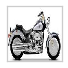

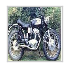

In [12]:
# COMPARA DUAS IMAGENS PARECIDAS PRA VALIDAR AS FEATURES
index_img_1 = 0
index_img_2 = 6
distance = cosine(loaded_features[index_img_1], loaded_features[index_img_2])
print(distance)
print_image(all_images, index_img_1)
print_image(all_images, index_img_2)

0.7651122510433197


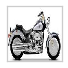

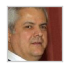

In [13]:
# COMPARA DUAS IMAGENS DE CLASSES DIFERENTES PRA VALIDAR AS FEATURES
index_img_1 = 0
index_img_2 = 799
distance = cosine(loaded_features[index_img_1], loaded_features[index_img_2])
print(distance)
print_image(all_images, index_img_1)
print_image(all_images, index_img_2)

# 2 Aplicação de Algoritmos de Agrupamento de Dados

### 2.1 Partitioning-based

In [120]:
# Inicializa Dataframe para plotar resultados
images_transformed = umap.UMAP(n_neighbors=5).fit_transform(loaded_features.data)
_df = pd.DataFrame(images_transformed, columns=['x', 'y'])

/home/bruna/anaconda3/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


In [15]:
# Função auxiliar para printar as imagens de cada cluster
def print_cluster_images(cluster, labels):  
    plt.rcParams["figure.figsize"] = (25,35) 
    columns = 6
    rows = math.ceil((list(labels)).count(cluster)/columns)
    fig=plt.figure()

    end = columns*rows + 1
    i = 1
    for index in range(len(labels)):
        if(labels[index] == cluster):
            img = all_images[index]
            fig.add_subplot(rows, columns, i)
            plt.axis('off')
            plt.imshow(img)
            i += 1
        if i == end:
            break
    plt.show()
    plt.rcParams["figure.figsize"] = (15,5)

### 2.1.a - Kmeans

In [57]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(loaded_features)
print('Inércia do Kmeans: ', kmeans.inertia_)
len(kmeans.cluster_centers_)

Inércia do Kmeans:  553254.6024619204


6

In [41]:
df_kmeans = _df.copy()
df_kmeans['label'] = kmeans.labels_
df_kmeans.head()
len(kmeans.cluster_centers_)

6

6

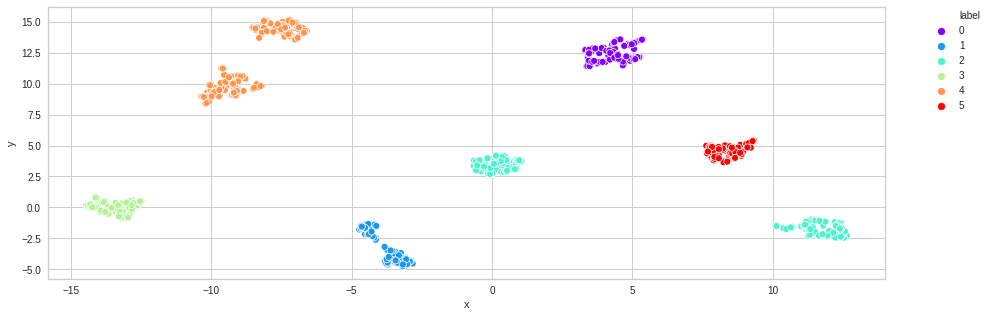

In [42]:
_ = sns.scatterplot(x='x', y='y', data=df_kmeans, hue='label', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
len(kmeans.cluster_centers_)

In [43]:
print(len(kmeans.cluster_centers_))

6


6


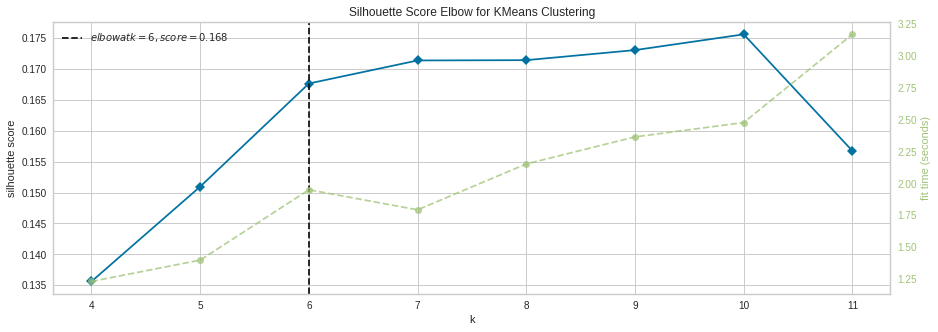

11
6


In [60]:
kmeans_copy = copy.copy(kmeans)
visualizer = KElbowVisualizer(kmeans_copy, k=(4,12), metric='silhouette', locate_elbow=True)
visualizer = visualizer.fit(loaded_features)
visualizer.show() 

# problema encontrado: plota de cluster 4 a 11, modificando kmeans.cluster_centers_ para 11, 
# independente do numero usado para fazer o kmeans. Não parece as designed
# resolver: fazer uma cópia do kmeans model apenas para plotar o elbow

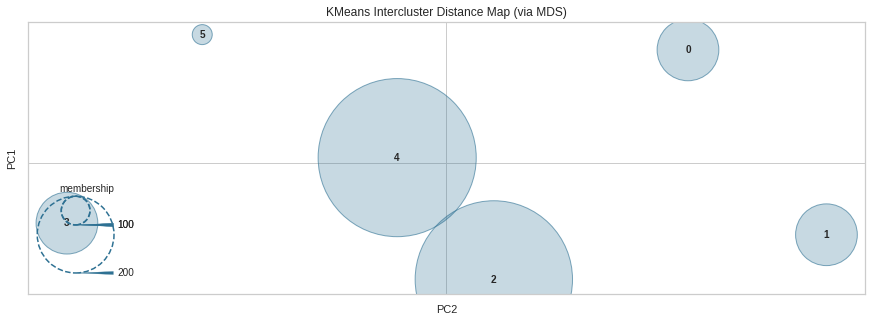

In [61]:
visualizer = InterclusterDistance(kmeans)
visualizer.fit(loaded_features)       
visualizer.show()       
# distancia entre os centros dos clusteres
# quanto mais próximos os centros, mais perto eles estão no espaço das features
# quanto maios o cluster, maior o score (numero de instâncias de cada custer) -> senso de importância do cluster


In [ ]:
print("Cluster", 0)
print_cluster_images(0, kmeans.labels_)

### 2.1.b - KMedoids

In [67]:
kmedoids = KMedoids(n_clusters=len(classes), random_state=0).fit(feature_list)
print('Inércia do KMedoids: ', kmedoids.inertia_)
# print(kmedoids.labels_)
# reduced_data = PCA(n_components=len(classes)).fit_transform(feature_list)

# print(dir(reduced_data))

Inércia do KMedoids:  25259.21


In [ ]:
print("Cluster", 0)
print_cluster_images(0, kmedoids.labels_)

In [ ]:
print("Cluster", 1)
print_cluster_images(1, kmedoids.labels_)

In [68]:
df_kmedoids = _df
df_kmedoids['label'] = kmedoids.labels_
df_kmedoids.head()


,x,y,label
0,11.106021,-1.452812,0
1,11.266781,-2.235116,0
2,11.405410,-1.194097,0
3,12.397524,-1.258866,0
4,12.325777,-1.415147,0


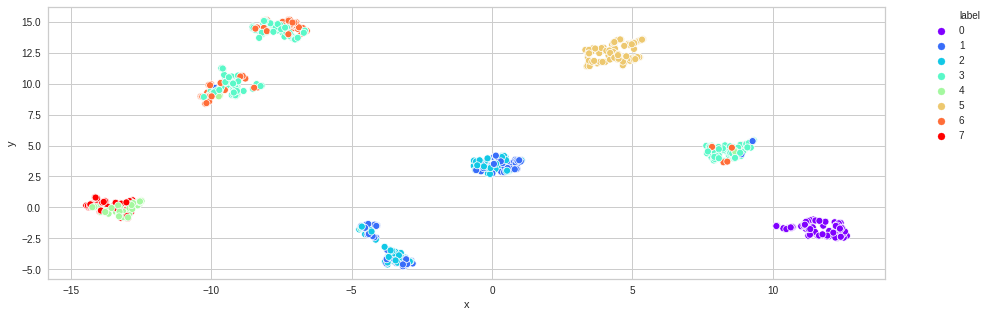

In [69]:
_ = sns.scatterplot(x='x', y='y', data=df_kmedoids, hue='label', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### 2.1.c - Mini Batch KMeans

In [71]:
miniBatchKmeans = MiniBatchKMeans(n_clusters=len(classes), random_state=0).fit(feature_list)

print('Inércia do Mini Batch Kmeans: {}\n'.format(miniBatchKmeans.inertia_))
# print('Labels: ', miniBatchKmeans.labels_)


Inércia do Mini Batch Kmeans: 505009.2214249524



In [ ]:
print("Cluster", 0)
print_cluster_images(0, miniBatchKmeans.labels_)

In [ ]:
print("Cluster", 1)
print_cluster_images(1, miniBatchKmeans.labels_)

In [ ]:
print("Cluster", 2)
print_cluster_images(2, miniBatchKmeans.labels_)

In [72]:
df_miniBatchKmeans = _df
df_miniBatchKmeans['label'] = miniBatchKmeans.labels_
df_miniBatchKmeans.head()


,x,y,label
0,11.106021,-1.452812,4
1,11.266781,-2.235116,4
2,11.405410,-1.194097,4
3,12.397524,-1.258866,4
4,12.325777,-1.415147,4


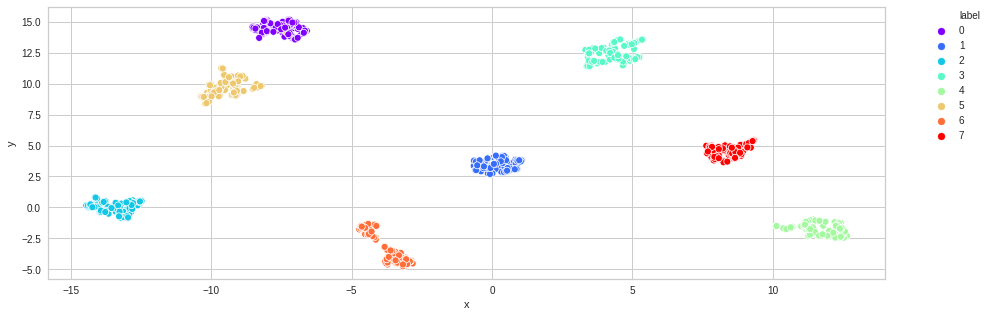

In [73]:
_ = sns.scatterplot(x='x', y='y', data=df_miniBatchKmeans, hue='label', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### 2.2 Hierarchical-based

### 2.2.a Hierarchical Agglomerative Clustering - Single Linkage

In [75]:
Z = ward(pdist(feature_list))
clusters = fcluster(Z, t=0.9, criterion='distance')


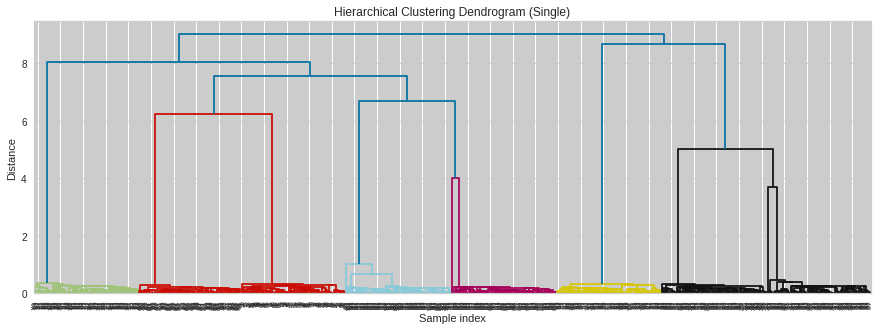

In [77]:
df_single = _df
linkage_matrix_single = linkage(df_single, method='single')
plt.title('Hierarchical Clustering Dendrogram (Single)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
d = dendrogram(linkage_matrix_single)


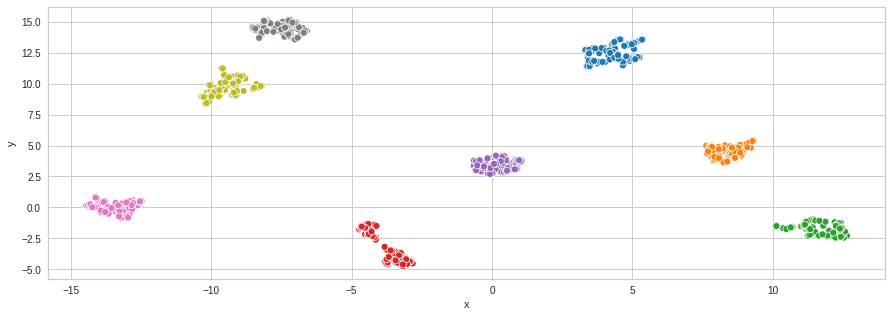

In [78]:
single_link_labels = fcluster(linkage_matrix_single, 1.6, 'distance')
df_single['labels'] = single_link_labels
_ = sns.scatterplot(x='x', y='y', data=df_single, hue='labels', palette='tab10', legend=False)

### 2.2.b Hierarchical Agglomerative Clustering - Complete Linkage

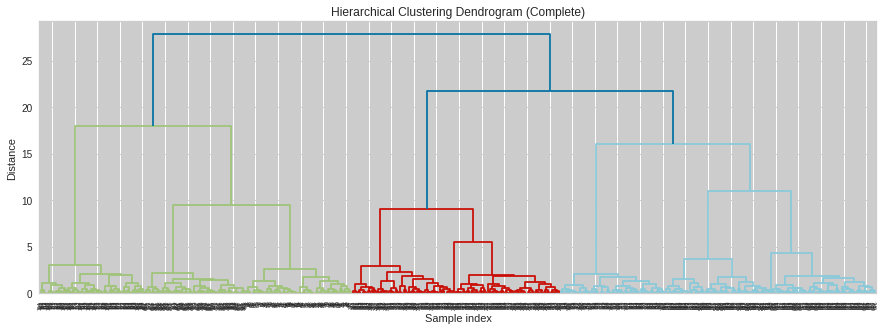

In [79]:
df_complete = _df
linkage_matrix_complete = linkage(df_complete, method='complete')
plt.title('Hierarchical Clustering Dendrogram (Complete)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
d = dendrogram(linkage_matrix_complete)

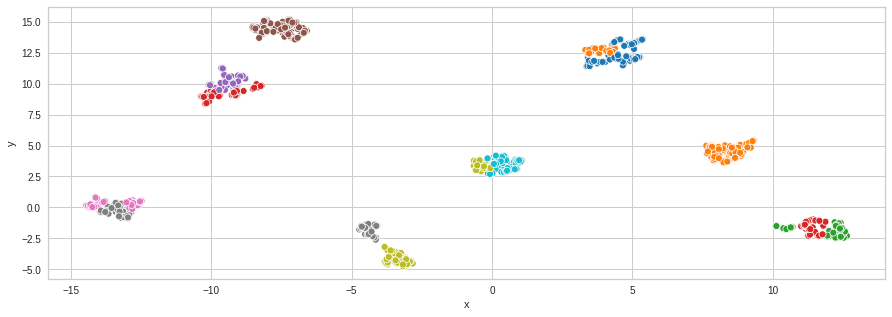

In [80]:
complete_link_labels = fcluster(linkage_matrix_complete, 1.6, 'distance')
df_complete['labels'] = complete_link_labels
_ = sns.scatterplot(x='x', y='y', data=df_complete, hue='labels', palette='tab10', legend=False)

### 2.2.c Hierarchical Agglomerative Clustering - Average Linkage

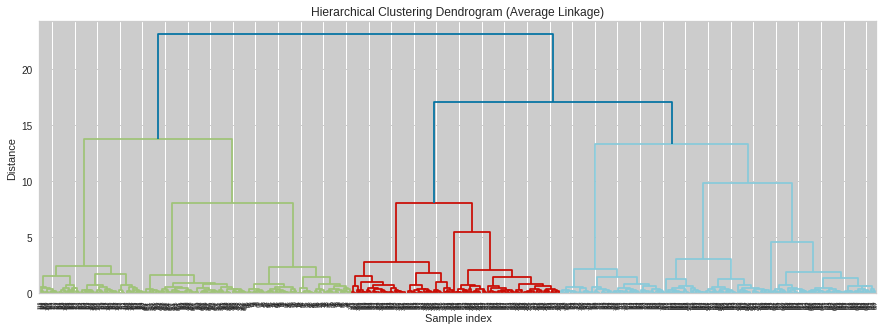

In [81]:
df_average = _df
linkage_matrix_avg = linkage(df_average, method='average')
plt.title('Hierarchical Clustering Dendrogram (Average Linkage)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
d = dendrogram(linkage_matrix_avg)


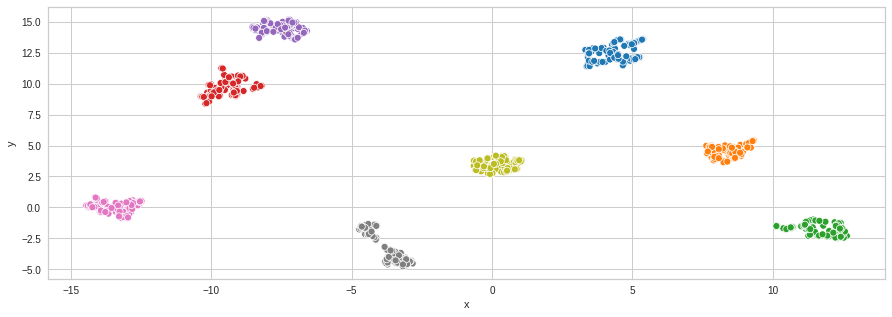

In [100]:
avg_link_labels = fcluster(linkage_matrix_avg, 3.5, 'distance')
df_average['labels'] = avg_link_labels
_ = sns.scatterplot(x='x', y='y', data=df_complete, hue='labels', palette='tab10', legend=False)

### Density-based

In [115]:
#  sklearn.cluster.DBSCAN
from sklearn.cluster import DBSCAN
X = loaded_features
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
clustering.labels_
DBSCAN(eps=3, min_samples=2)

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

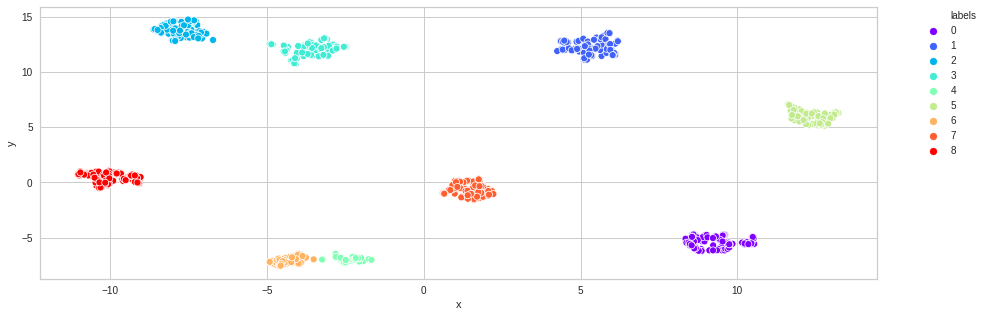

In [124]:
eps = 0.5 # pq esse numero??
min_samples = 5 #pq metodo elbow apontou 6 como o ideal
    
# Copiamos os dados e removemos a coluna label 
df_dbscan = _df.copy()
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(df_dbscan)

df_dbscan['labels'] = dbscan.labels_
_ = sns.scatterplot(x='x', y='y', data=df_dbscan, hue='labels', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Grid-based

### Model-based

# 3 Avaliação do resultado dos agrupamentos de dados

### Quantitativas

#### Interno

In [102]:
X = loaded_features
dict = {}

dict['kmeans'] = davies_bouldin_score(X, kmeans.labels_)
dict['kmedoids'] = davies_bouldin_score(X, kmedoids.labels_)
dict['kmeans minibatch'] = davies_bouldin_score(X, miniBatchKmeans.labels_)
dict['single link'] = davies_bouldin_score(X, single_link_labels)
dict['complete link'] = davies_bouldin_score(X, complete_link_labels)
dict['average link'] = davies_bouldin_score(X, avg_link_labels)

df = pd.DataFrame(list(dict.items())) 
df = pd.DataFrame(list(dict.items()), columns=['Algorithm', 'Davies Score'])
df.style.hide_index()

Algorithm,Davies Score
kmeans,2.06105
kmedoids,4.75438
kmeans minibatch,2.05019
single link,1.77089
complete link,3.29517
average link,1.77089


#### Externo

In [103]:
# Adjusted Rand Index (ARI)

data = np.array(all_classes)
mapper_dict = {'motorbike': 0, 'fruit': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'airplane': 5, 'car': 6, 'person': 7}

# mapeia vetor true labels em string para inteiros
def mp(entry):
    return mapper_dict[entry] if entry in mapper_dict else entry
mp = np.vectorize(mp)

labels_true = mp(data)
labels_pred = kmeans.labels_

adjusted_rand_score(labels_true, labels_pred)
# all_classes
# labels_pred

0.7565023685681007

In [104]:
# Adjusted Rand Index (ARI)
data = np.array(all_classes)
mapper_dict = {'motorbike': 0, 'fruit': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'airplane': 5, 'car': 6, 'person': 7}

def mp(entry):
    return mapper_dict[entry] if entry in mapper_dict else entry
mp = np.vectorize(mp)

labels_true = mp(data)
dict = {}

dict['kmeans'] = adjusted_rand_score(labels_true, kmeans.labels_)
dict['kmedoids'] = adjusted_rand_score(labels_true, kmedoids.labels_)
dict['kmeans minibatch'] = adjusted_rand_score(labels_true, miniBatchKmeans.labels_)
dict['single link'] = adjusted_rand_score(labels_true, single_link_labels)
dict['complete link'] = adjusted_rand_score(labels_true, complete_link_labels)
dict['average link'] = adjusted_rand_score(labels_true, avg_link_labels)

df = pd.DataFrame(list(dict.items())) 
df = pd.DataFrame(list(dict.items()), columns=['Algorithm', 'ARI'])
df.style.hide_index()

Algorithm,ARI
kmeans,0.756502
kmedoids,0.534046
kmeans minibatch,0.988572
single link,0.988562
complete link,0.512141
average link,0.988562


#### Relativo

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)       
visualizer.show()        

In [ ]:
visualizer = SilhouetteVisualizer(kmedoids, colors='yellowbrick')
visualizer.fit(X)       
visualizer.show()   

In [ ]:
visualizer = SilhouetteVisualizer(miniBatchKmeans, colors='yellowbrick')
visualizer.fit(X)       
visualizer.show()        

In [ ]:
# elbow: aponta kmeans com 6 clusters com maior score
# resultado treinando com 6 clusters: motos + carros e gatos + cachorros no mesmo grupo